# 3D vascular segmentation of the liver with TOPNET

This tutorial shows how to integrate MONAI into an existing PyTorch medical DL program.

And easily use below features:
1. Transforms for dictionary format data.
1. Load Nifti image with metadata.
1. Add channel dim to the data if no channel dimension.
1. Scale medical image intensity with expected range.
1. Crop out a batch of balanced images based on positive / negative label ratio.
1. Cache IO and transforms to accelerate training and validation.
2. 3D TopNet model, Dice loss function,  clDice metric for 3D segmentation task.
3. Sliding window inference method.
4. Deterministic training for reproducibility.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1XfX0B0XP5aS5ALEbq_F046IAdqF6WRst)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 7.2 

## Setup imports

In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import numpy as np
import torch
from torch import nn
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torch.nn.modules import Module
import torch.nn._reduction as _Reduction
import matplotlib.pyplot as plt
import scipy
import tempfile
import shutil
from skimage.morphology import skeletonize, skeletonize_3d
import os
import glob

print_config()

MONAI version: 1.4.dev2412
Numpy version: 1.25.2
Pytorch version: 2.2.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 66af634f24d71a71a281a3325a33df9418627320
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 9.4.0
Tensorboard version: 2.15.2
gdown version: 4.7.3
TorchVision version: 0.17.1+cu121
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.38.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.i

## Setup data directory


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
root_dir = os.path.join("/content/drive/MyDrive/ProCom/")
print(root_dir)

/content/drive/MyDrive/ProCom/


## Set MSD Spleen dataset path

In [5]:
images = sorted(glob.glob(os.path.join(root_dir, "Data/*VE.nii.gz")))
labels = sorted(glob.glob(os.path.join(root_dir, "Data/*VE-por.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(images, labels)]
train_files, val_files, test_files = data_dicts[:-6], data_dicts[-2:], data_dicts[-6:-2]
print(train_files, val_files)

[{'image': '/content/drive/MyDrive/ProCom/Data/01-VE.nii.gz', 'label': '/content/drive/MyDrive/ProCom/Data/01-VE-por.nii.gz'}, {'image': '/content/drive/MyDrive/ProCom/Data/02-VE.nii.gz', 'label': '/content/drive/MyDrive/ProCom/Data/02-VE-por.nii.gz'}, {'image': '/content/drive/MyDrive/ProCom/Data/03-VE.nii.gz', 'label': '/content/drive/MyDrive/ProCom/Data/03-VE-por.nii.gz'}, {'image': '/content/drive/MyDrive/ProCom/Data/04-VE.nii.gz', 'label': '/content/drive/MyDrive/ProCom/Data/04-VE-por.nii.gz'}, {'image': '/content/drive/MyDrive/ProCom/Data/05-VE.nii.gz', 'label': '/content/drive/MyDrive/ProCom/Data/05-VE-por.nii.gz'}, {'image': '/content/drive/MyDrive/ProCom/Data/06-VE.nii.gz', 'label': '/content/drive/MyDrive/ProCom/Data/06-VE-por.nii.gz'}, {'image': '/content/drive/MyDrive/ProCom/Data/07-VE.nii.gz', 'label': '/content/drive/MyDrive/ProCom/Data/07-VE-por.nii.gz'}, {'image': '/content/drive/MyDrive/ProCom/Data/08-VE.nii.gz', 'label': '/content/drive/MyDrive/ProCom/Data/08-VE-por.n

## Set deterministic training for reproducibility

In [6]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
2. `Orientationd` unifies the data orientation based on the affine matrix.
3. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.

In [7]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
    ]
)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


## Check transforms in DataLoader

image shape: torch.Size([256, 256, 128]), label shape: torch.Size([256, 256, 128])


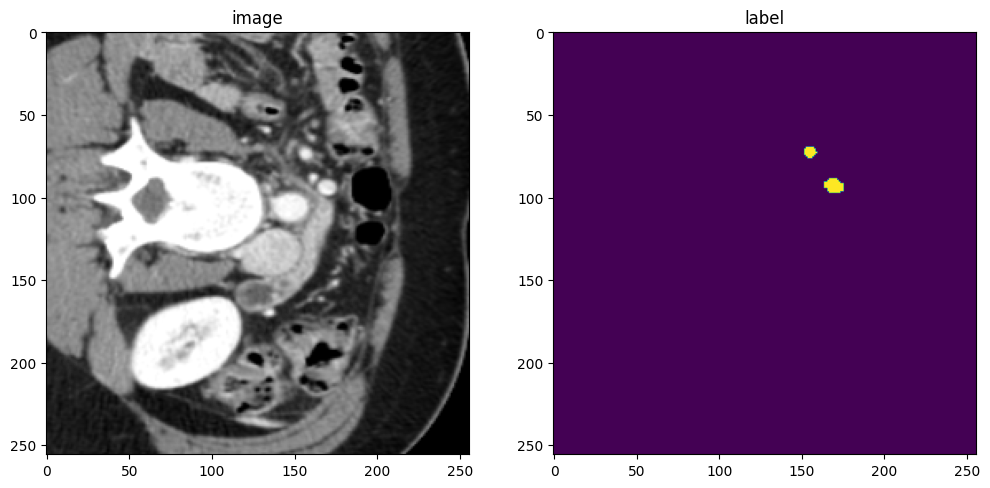

In [8]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 0], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 0])
plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [9]:
#train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
#val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loading dataset: 100%|██████████| 2/2 [00:02<00:00,  1.47s/it]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_

## Create TopNet architecture

In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
                nn.Conv3d(in_channels, out_channels//2, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm3d(out_channels//2),
                nn.ReLU(inplace=True),
                nn.Conv3d(out_channels//2, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm3d(out_channels),
                nn.ReLU(inplace=True)
            )

    def forward(self, x):
        return self.conv(x)

In [11]:
def move_up(x, skip_connections, ups):
    for idx in range(0, len(ups), 2):
        x = ups[idx](x)
        skip_connection = skip_connections[idx//2]

        if x.shape != skip_connection.shape:
            x = F.interpolate(x, size=skip_connection.shape[2:], mode='trilinear', align_corners=False)

        concat_skip = torch.cat((skip_connection, x), dim=1)
        x = ups[idx+1](concat_skip)
    return x

In [12]:
class TopNET(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[16, 32, 64, 128, 256]):
        super(TopNET, self).__init__()

        self.downs = nn.ModuleList()
        self.ups1 = nn.ModuleList()
        self.ups2 = nn.ModuleList()
        #self.ups3 = nn.ModuleList()
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=1)

        # Down part of the TopNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # 1st Up part of the TopNET
        for feature in reversed(features):
            self.ups1.append(nn.ConvTranspose3d(feature*2, feature, kernel_size=2, stride=2))
            self.ups1.append(DoubleConv(feature*2, feature))

        # 2nd Up part of the TopNET
        for feature in reversed(features):
            self.ups2.append(nn.ConvTranspose3d(feature*2, feature, kernel_size=2, stride=2))
            self.ups2.append(DoubleConv(feature*2, feature))

        # 3rd Up part of the TopNET
        #for feature in reversed(features):
            #self.ups3.append(nn.ConvTranspose3d(feature*2, feature, kernel_size=2, stride=2))
            #self.ups3.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        #self.final_conv1 = nn.Softmax(dim=1)
        self.final_conv1 = nn.Conv3d(features[0], out_channels, kernel_size=1)
        self.final_conv2 = nn.ReLU(inplace=False)
        #self.final_conv3 = nn.Conv3d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x1 = self.bottleneck(x)
        x2 = self.bottleneck(x)
        #x3 = self.bottleneck(x3)
        skip_connections = skip_connections[::-1]

        x1 = move_up(x1, skip_connections, self.ups1)
        x2 = move_up(x2, skip_connections, self.ups2)
        #x3 = move_up(x3, skip_connections, self.ups3)

        out1 = self.final_conv1(x1)
        out2 = self.final_conv2(x2)
        #out3 = self.final_conv3(x3)

        if self.training:
          return out1, out2#, out3
        else :
          return out1

## Centerness Loss

In [13]:
class _Loss(Module):
    reduction: str

    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean') -> None:
        super().__init__()
        if size_average is not None or reduce is not None:
            self.reduction: str = _Reduction.legacy_get_string(size_average, reduce)
        else:
            self.reduction = reduction

class CenternessLoss(_Loss):
    __constants__ = ['reduction']
    def __init__(self, size_average=None, reduce=None, reduction: str = 'none', beta: float = 1.5):
        super().__init__(size_average, reduce, reduction)
        self.beta = beta

    def forward(self, input, target, binary_target):
        # Mask out voxels outside the vessel region
        input_masked = input * binary_target
        target_masked = target * binary_target

        # SmoothL1 loss
        smoothL1 = F.smooth_l1_loss(input_masked, target_masked, reduction=self.reduction, beta=self.beta)

        # Weight the loss with the inverse square of true centerness score
        weight = 1 / (target_masked**2 + 1e-8)  # Adding a small epsilon to avoid division by zero
        loss = torch.sum(weight * smoothL1) / torch.sum(binary_target)

        return loss


## Topological Distance Loss


In [ ]:
class TopologicalDistanceLoss(torch.nn.Module):
    def __init__(self, alpha=1/15, gamma=1/3, K=3):
        super(TopologicalDistanceLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.K = K

    def forward(self, features, vessel_labels):
        # Assuming features is a tensor of shape (batch_size, 8, spatial_dim1, spatial_dim2, spatial_dim3)
        # and vessel_labels is a binary tensor of shape (batch_size, 1, spatial_dim1, spatial_dim2, spatial_dim3)

        batch_size, _, spatial_dim1, spatial_dim2, spatial_dim3 = features.shape

        # Flatten the features and labels
        features_flat = features.view(batch_size, 8, -1)
        vessel_labels_flat = vessel_labels.view(batch_size, -1)

        total_loss = 0.0

        for i in range(batch_size):
            mask = vessel_labels_flat[i] == 1
            neighborhood_indices = self.get_local_neighborhood_indices(mask, spatial_dim1, spatial_dim2, spatial_dim3)

            # Calculate the pairwise loss for each pair of voxels in the neighborhood
            pairwise_loss = self.pairwise_loss(features_flat[i], neighborhood_indices)

            # Sum the pairwise losses and take the average
            total_loss += torch.sum(pairwise_loss) / len(neighborhood_indices)

        # Take the average loss over the batch
        total_loss /= batch_size

        return total_loss

    def pairwise_loss(self, features, neighborhood_indices):
        pairwise_losses = []

        for i in range(len(neighborhood_indices)):
            for j in range(i + 1, len(neighborhood_indices)):
                idx_i, idx_j = neighborhood_indices[i], neighborhood_indices[j]

                # Calculate L2 norm between feature representations of the two voxels
                l2_norm = torch.norm(features[:, idx_i] - features[:, idx_j], dim=0)

                if idx_i == idx_j:
                    # Smooth L1 loss for the same vessel
                    pairwise_losses.append(F.smooth_l1_loss(l2_norm, self.alpha * idx_i))
                else:
                    # Gamma * max(0, K - L2 norm) for different vessels
                    pairwise_losses.append(self.gamma * torch.max(torch.tensor(0.0).to(l2_norm.device), self.K - l2_norm))

        return torch.stack(pairwise_losses)

    def get_local_neighborhood_indices(self, mask, spatial_dim1, spatial_dim2, spatial_dim3):
        # Assuming 3D sphere of radius 15 voxels
        radius = 15
        local_indices = []

        for idx in range(len(mask)):
            if mask[idx] == 1:
                # Convert 1D index to 3D coordinates
                z = idx // (spatial_dim1 * spatial_dim2)
                y = (idx % (spatial_dim1 * spatial_dim2)) // spatial_dim1
                x = (idx % (spatial_dim1 * spatial_dim2)) % spatial_dim1

                # Get indices within the 3D sphere
                indices = self.get_indices_in_3d_sphere(x, y, z, spatial_dim1, spatial_dim2, spatial_dim3, radius)

                # Append indices to the list
                local_indices.append(indices)

        return local_indices

    def get_indices_in_3d_sphere(self, x, y, z, spatial_dim1, spatial_dim2, spatial_dim3, radius):
        indices = []

        for i in range(max(0, x - radius), min(x + radius + 1, spatial_dim1)):
            for j in range(max(0, y - radius), min(y + radius + 1, spatial_dim2)):
                for k in range(max(0, z - radius), min(z + radius + 1, spatial_dim3)):
                    # Convert 3D coordinates to 1D index
                    index = k * (spatial_dim1 * spatial_dim2) + j * spatial_dim1 + i
                    indices.append(index)

        return indices

## CL Dice Metric

In [14]:
def cl_score(prediction, skeleton):
    #this function computes the skeleton volume overlap]
    return np.sum(prediction*skeleton)/np.sum(skeleton)


def clDice(prediction, mask):
    #this function computes the cldice metric]
    clDice_list = []
    for i in range(len(prediction)):
        prediction_image = prediction[i]
        mask_image = mask[i]
        if len(prediction_image.shape)==2:
            tprec = cl_score(prediction_image,skeletonize(mask_image))
            tsens = cl_score(mask_image,skeletonize(prediction_image))
        elif len(prediction_image.shape)==3:
            tprec = cl_score(prediction_image,skeletonize_3d(mask_image))
            tsens = cl_score(mask_image,skeletonize_3d(prediction_image))
        clDice_list.append(2*tprec*tsens/(tprec+tsens))
    return np.mean(clDice_list)

## Execute a typical PyTorch training process

In [15]:
# standard PyTorch program style: create TopNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = TopNET(in_channels = 1, out_channels = 2).to(device)

weights = os.path.join(root_dir, "best_metric_model_closs_clDice_fin0.3_600.pth")
model.load_state_dict(torch.load(weights, map_location=device))

loss_function1 = DiceLoss(to_onehot_y=True, softmax=True)
#loss_function2 = torch.nn.SmoothL1Loss()
loss_function2 = CenternessLoss()

optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [ ]:
max_epochs = 100
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss1_values = []
epoch_loss2_values = []
epoch_loss_values = []
metric_values = []
loss_weight = 0.25
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss1 = 0
    epoch_loss2 = 0
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        output1, output2 = model(inputs)
        loss1 = loss_function1(output1, labels)
        label2 = scipy.ndimage.distance_transform_edt(labels)
        label2 = torch.tensor(label2).to(device)
        #label2 = torch.nn.functional.one_hot(label2, num_classes=16)
        #loss2 = loss_function2(output2, label2)
        loss2 = loss_function2(output2, label2, labels)
        loss = loss_weight*loss1 + (1-loss_weight)*loss2
        loss.backward()
        optimizer.step()
        epoch_loss1 += loss1.item()
        epoch_loss2 += loss2.item()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        torch.cuda.empty_cache()
    epoch_loss1 /= step
    epoch_loss2 /= step
    epoch_loss /= step
    epoch_loss1_values.append(epoch_loss1)
    epoch_loss2_values.append(epoch_loss2)
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        metric_list = []
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                #dice_metric(y_pred=val_outputs, y=val_labels)
                metric_list.append(clDice(prediction=val_outputs[0].cpu().data.numpy(), mask=val_labels[0].cpu().data.numpy()))

            # aggregate the final mean dice result
            #metric = dice_metric.aggregate().item()
            metric = np.mean(metric_list)
            # reset the status for next validation round
            #dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_closs_clDice0.3_700.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
    torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_closs_clDice_fin0.3_700.pth"))

----------
epoch 1/100


/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1386: UserWarning: Using a target size (torch.Size([8, 1, 96, 96, 96])) that is different to the input size (torch.Size([8, 16, 96, 96, 96])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret = func(*args, **kwargs)


1/7, train_loss: 0.0303
2/7, train_loss: 0.0383
3/7, train_loss: 0.0993
4/7, train_loss: 0.0249
5/7, train_loss: 0.0494
6/7, train_loss: 0.0497
7/7, train_loss: 0.0459
epoch 1 average loss: 0.0483
----------
epoch 2/100
1/7, train_loss: 0.0661
2/7, train_loss: 0.0283
3/7, train_loss: 0.0272
4/7, train_loss: 0.0361
5/7, train_loss: 0.0573
6/7, train_loss: 0.0305
7/7, train_loss: 0.0613
epoch 2 average loss: 0.0438
saved new best metric model
current epoch: 2 current mean dice: 0.7444
best mean dice: 0.7444 at epoch: 2
----------
epoch 3/100
1/7, train_loss: 0.0322
2/7, train_loss: 0.0409
3/7, train_loss: 0.0378
4/7, train_loss: 0.0436
5/7, train_loss: 0.0245
6/7, train_loss: 0.0570
7/7, train_loss: 0.0457
epoch 3 average loss: 0.0402
----------
epoch 4/100
1/7, train_loss: 0.0315
2/7, train_loss: 0.0352
3/7, train_loss: 0.0612
4/7, train_loss: 0.0284
5/7, train_loss: 0.0260
6/7, train_loss: 0.0289
7/7, train_loss: 0.0254
epoch 4 average loss: 0.0338
saved new best metric model
current e

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

## Plot the loss and metric

In [ ]:
plt.figure("train", (20, 6))
plt.subplot(1, 4, 1)
plt.title("Epoch Average Loss 1 : Dice Loss")
x1 = [i + 1 for i in range(len(epoch_loss1_values))]
y1 = epoch_loss1_values
plt.xlabel("epoch")
plt.plot(x1, y1)
plt.subplot(1, 4, 2)
plt.title("Epoch Average Loss 2 : L1 Loss")
x2 = [i + 1 for i in range(len(epoch_loss2_values))]
y2 = epoch_loss2_values
plt.xlabel("epoch")
plt.plot(x2, y2)
plt.subplot(1, 4, 3)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 4, 4)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_closs_clDice0.3_700.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

## Evaluation on original image spacings

In [16]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        #Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        #ScaleIntensityRanged(
            #keys=["image"],
            #a_min=-57,
            #a_max=164,
            #b_min=0.0,
            #b_max=1.0,
            #clip=True,
        #),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)

val_org_ds = Dataset(data=val_files, transform=test_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=test_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        AsDiscreted(keys="label", to_onehot=2),
    ]
)

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [ ]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_closs_clDice0.3_700.pth")))
model.eval()

metric_list = []
with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)
        metric_list.append(clDice(prediction=val_outputs[0].cpu().data.numpy(), mask=val_labels[0].cpu().data.numpy()))


    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    metric = np.mean(metric_list)
    # reset the status for next validation round
    dice_metric.reset()

print("Dice Metric on original image spacing: ", metric_org)
print("CLDice Metric on original image spacing: ", metric)

## Inference on Test Set

In [17]:
test_org_ds = Dataset(data=test_files, transform=test_transforms)
test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=test_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        AsDiscreted(keys="label", to_onehot=2),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
    ]
)

In [18]:
# # uncomment the following lines to visualize the predicted results
from monai.transforms import LoadImage
loader = LoadImage()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


2024-03-28 12:10:15,235 INFO image_writer.py:197 - writing: out/15-VE/15-VE_seg.nii.gz


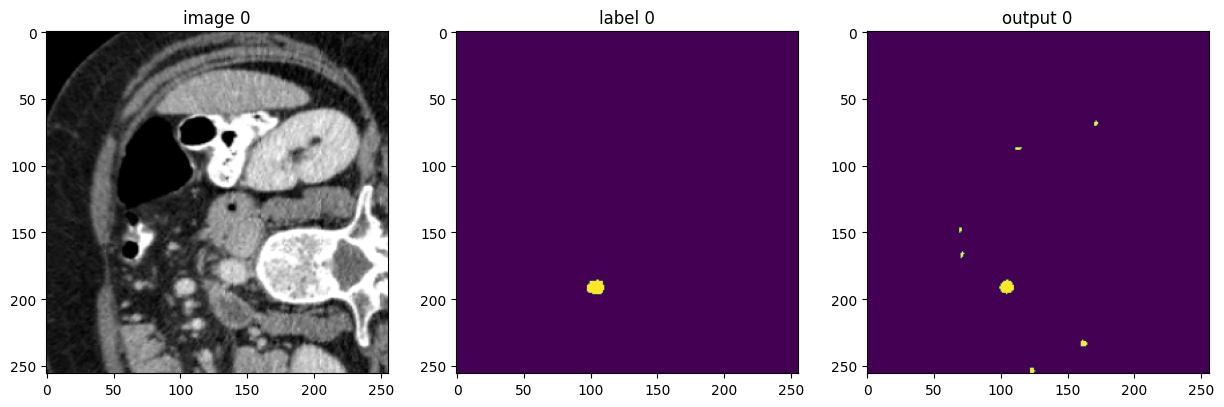

2024-03-28 12:10:39,201 INFO image_writer.py:197 - writing: out/16-VE/16-VE_seg.nii.gz


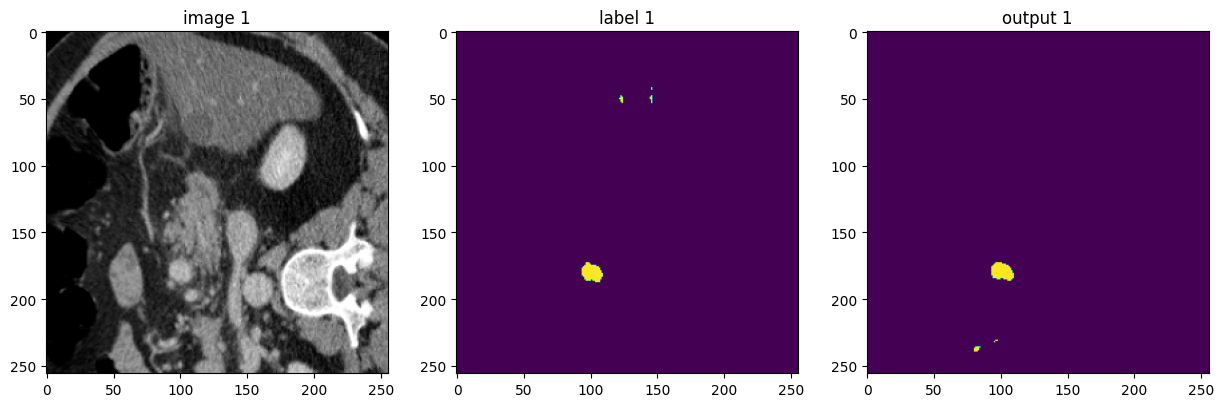

2024-03-28 12:11:04,228 INFO image_writer.py:197 - writing: out/17-VE/17-VE_seg.nii.gz


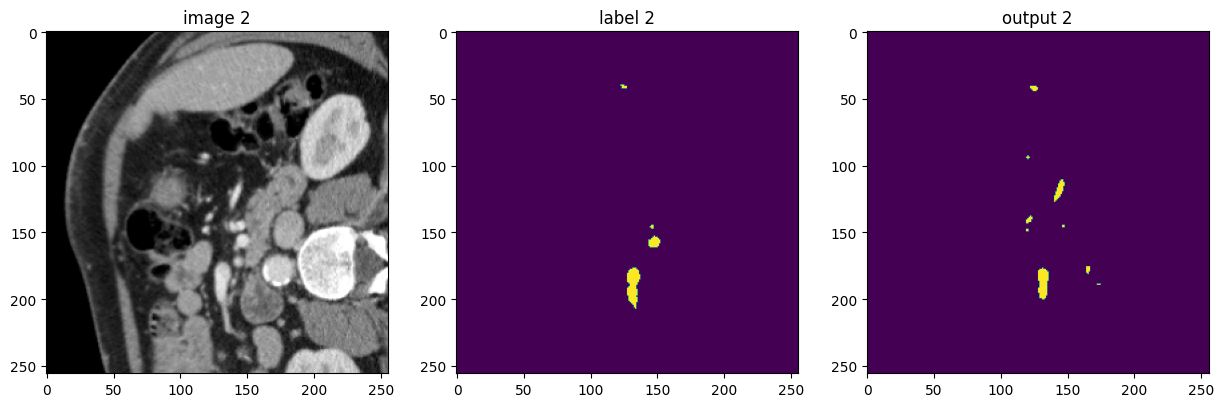

2024-03-28 12:11:30,475 INFO image_writer.py:197 - writing: out/18-VE/18-VE_seg.nii.gz


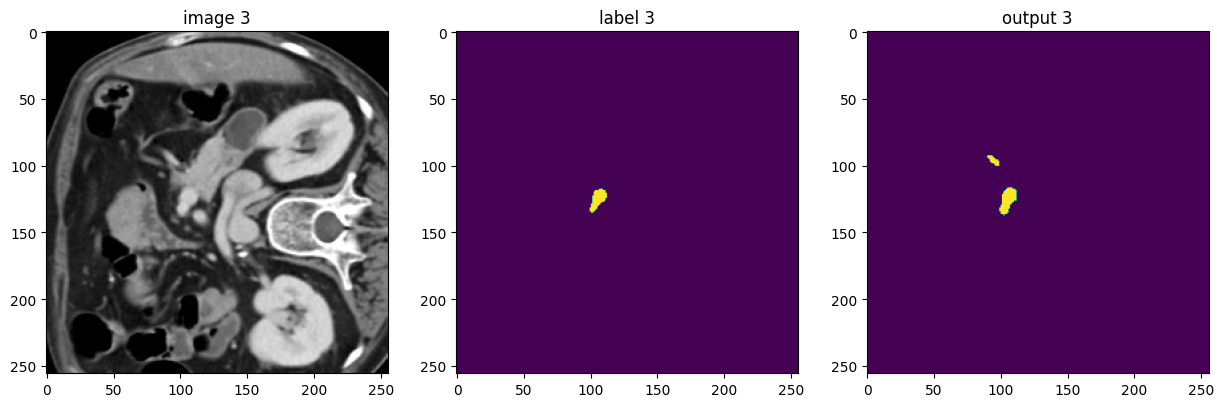

Dice Score on test images:  0.6061428189277649
clDice Score on test images:  0.7753170045235971


In [20]:
import nibabel

model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_closs_clDice0.75_600.pth")))
model.eval()
i=0
metric_list = []
with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

#         # uncomment the following lines to visualize the predicted results
        test_output, test_label = from_engine(["pred", "label"])(test_data)

        original_image = loader(test_output[0].meta["filename_or_obj"])
        original_label = loader(test_label[0].meta["filename_or_obj"])

        plt.figure("Inference", (15, 20))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(original_image[:, :, 20], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(original_label[:, :, 20])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_output[0].detach().cpu()[1, :, :, 20])
        plt.show()

        i+=1
        dice_metric(y_pred=test_output, y=test_label)
        metric_list.append(clDice(prediction=test_output[0].cpu().data.numpy(), mask=test_label[0].cpu().data.numpy()))


    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    metric = np.mean(metric_list)
    # reset the status for next validation round
    dice_metric.reset()

print("Dice Score on test images: ", metric_org)
print("clDice Score on test images: ", metric)

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
#if directory is None:
   # shutil.rmtree(root_dir)